This notebook generates a single linear model using dynamic mode decomposition with control


In [100]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

config = dotenv_values(".env")


In [101]:
# Read in data 
filepath = config["currentDirectory"] + "data/processedData/cleanedArrays.npz"

with np.load(filepath) as data:
    stateData = data['stateData']
    inputData = data['inputData']
    centerlineData = data['centerlineData']


In [102]:
# Subtract initial state from everything to shift states to origin
stateData_centered = stateData-stateData[0,:]
centerlineData_centered = centerlineData-centerlineData[0,:]

# Reshape data 
stateData_centeredT = np.transpose(stateData_centered)
stateDataT = np.transpose(stateData_centeredT)

centerlineData_centeredT = np.transpose(centerlineData_centered) 
inputDataT = np.transpose(inputData) 

In [103]:
# Form snapshot matrices for DMD
Ndata = 750 # number of timesteps to use for DMD
X = stateDataT[:,0:Ndata]
Xprime = stateDataT[:,1:Ndata+1]
Upsilon = inputDataT[:,0:Ndata]

Omega = np.concatenate([X,Upsilon],axis=0)

n = X.shape[0] # size of state space 
l = Upsilon.shape[0] # number of inputs
m = centerlineData_centeredT.shape[0] # number of outputs

In [104]:
# Decompose snapshot matrix
U, Sigma, Vh = np.linalg.svd(Omega, full_matrices=False)
UPrime, SigmaPrime, VhPrime=np.linalg.svd(Xprime, full_matrices=False)

In [105]:
# Truncate the svd matrices
p = 100 # Truncation value for input space
r = 50 # Truncation value for output space
# Truncate input space SVD
U_tilde = U[:,0:p]
Sigma_tilde = np.diag(Sigma[0:p])
Vh_tilde = Vh[0:p,:]
# Truncate output space SVD 
U_hat = UPrime[:,0:r]
Sigma_hat = np.diag(SigmaPrime[0:r])
Vh_hat = VhPrime[:,0:r]




In [106]:
# Compute system state evolution matrices
U_tilde_1 = U_tilde[0:n,:]
U_tilde_2 = U_tilde[n:,:]
A_tilde = (U_hat.conj().T)@Xprime@(Vh_tilde.conj().T)@(np.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)@U_hat
B_tilde = (U_hat.conj().T)@Xprime@(Vh_tilde.conj().T)@(np.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)

In [107]:
#Simulate system state response
T = 200 # number of timesteps to simulate for 
x_rs = np.zeros((r,T))
u_rs = inputDataT[:,0:T]
for i in range(1,T):
    x_rs[:,[i]] = A_tilde@x_rs[:,[i-1]] + B_tilde@u_rs[:,[i-1]]

In [108]:
# solve for output matrix
ys = centerlineData_centeredT[:,0:T]
x_rs_PI = np.linalg.pinv(x_rs) 
C_tilde = ys@x_rs_PI

In [109]:
#Simulate system output response with learning set
T = 500 # number of timesteps to simulate for 
x_rs = np.zeros((r,T))
y_rs = np.zeros((m,T))
u_rs = inputDataT[:,0:T]
for i in range(1,T):
    x_rs[:,[i]] = A_tilde@x_rs[:,[i-1]] + B_tilde@u_rs[:,[i-1]]
    y_rs[:,[i]] = C_tilde@x_rs[:,[i]]



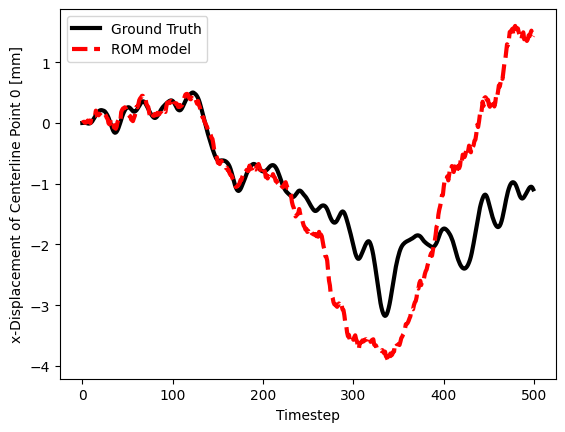

In [110]:
#Plot
plt.plot(range(T),centerlineData_centeredT[0,0:T], 'k-',lw=3)
plt.plot(range(T),y_rs[0,:],'r--',lw=3)
plt.legend(['Ground Truth','ROM model'])
plt.xlabel('Timestep')
plt.ylabel('x-Displacement of Centerline Point 0 [mm]')

plt.show()


# Verification


In [111]:
# Read in verification data
# Read in data 
testFilepath = config["currentDirectory"] + "data/processedData/testSet.npz"

with np.load(testFilepath) as data:
    stateData= data['stateData']
    inputData = data['inputData']
    centerlineData = data['centerlineData']
# Subtract initial state from everything to shift states to origin
stateData_centered = stateData-stateData[0,:]
centerlineData_centered = centerlineData-centerlineData[0,:]

# Reshape data 
centerlineData_centeredT = np.transpose(centerlineData_centered) 
inputDataT = np.transpose(inputData) 


In [112]:
##### Verification on test data set #######
T = 500 # number of timesteps to simulate for 
x_rs = np.zeros((r,T))
y_rs = np.zeros((m,T))
u_rs = inputDataT[:,0:T]
for i in range(1,T):
    x_rs[:,[i]] = A_tilde@x_rs[:,[i-1]] + B_tilde@u_rs[:,[i-1]]
    y_rs[:,[i]] = C_tilde@x_rs[:,[i]]


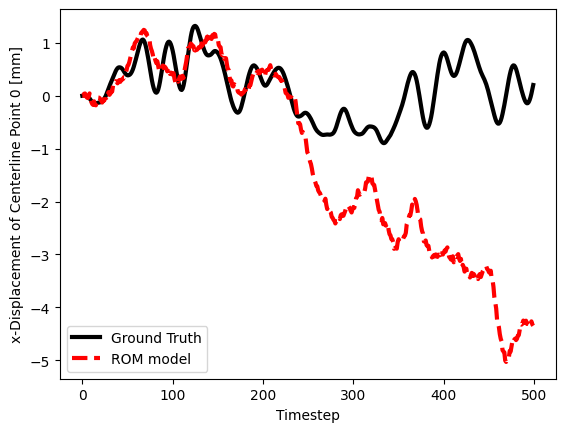

In [113]:
#Plot
plt.plot(range(T),centerlineData_centeredT[0,0:T], 'k-',lw=3)
plt.plot(range(T),y_rs[0,:],'r--',lw=3)
plt.legend(['Ground Truth','ROM model'])
plt.xlabel('Timestep')
plt.ylabel('x-Displacement of Centerline Point 0 [mm]')
plt.show()
